# Comparison of Light Curve Data
$$m_x= -5 \log_{100}(F/F_0)$$
$$F/F_0 = 100^{-m_x / 5}$$

## To-do
1. read data
2. convert to rel. flux
3. normalize flux readings
4. normalize julian dates
4. plot with data we have


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy.timeseries import BinnedTimeSeries

In [4]:
compare_dir = './analysis/comparison-data/'
tz_boo = pd.read_csv(compare_dir + 'TZ_Boo.csv')
cc_com = pd.read_csv(compare_dir + 'CC_Com.csv')

FileNotFoundError: [Errno 2] No such file or directory: './analysis/comparison-data/TZ_Boo.csv'

In [ ]:
def rel_flux(mag):
    return 100 ** (-mag / 5)

# process data and append to column

def append_flux_column(df):
    mag_column = df['V Band dm']
    flux = rel_flux(mag_column)
    flux = flux / flux.max()
    df['V Band Rel Flux'] = flux
    return df

In [68]:
append_flux_column(tz_boo)

,HJD,V Band dm,V Band Rel Flux
0,2455343.371,-0.468,1.000000
1,2455343.373,-0.454,0.987188
2,2455343.375,-0.433,0.968278
3,2455343.377,-0.422,0.958517
4,2455343.379,-0.422,0.958517
5,2455343.381,-0.411,0.948855
6,2455343.384,-0.395,0.934975
7,2455343.386,-0.380,0.922147
8,2455343.388,-0.368,0.912011
9,2455343.390,-0.353,0.899498


In [69]:
append_flux_column(cc_com)

,HJD,V Band dm,V Band Rel Flux
0,57868.62375,0.230,0.088308
1,57868.62473,0.191,0.091538
2,57868.62570,0.153,0.094798
3,58590.99775,-0.206,0.131947
4,58591.00543,-0.090,0.118577
5,58591.00652,-0.058,0.115133
6,58849.28544,-2.403,0.998160
7,58849.28606,-2.405,1.000000
8,58849.28667,-2.402,0.997241
9,58873.53431,-0.237,0.135769


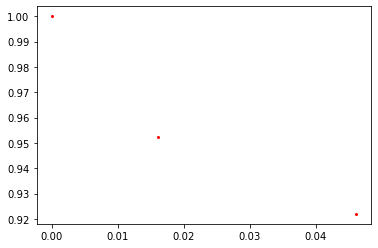

In [70]:
our_cc = BinnedTimeSeries.read(
    './analysis/results/cccom_results.csv',
    time_bin_start_column='time_bin_start',
    time_bin_size_column='time_bin_size',
    time_bin_size_unit=u.s
)
our_jd_cc = our_cc.time_bin_start.jd - our_cc.time_bin_start.jd.min()
plt.plot(our_jd_cc, our_cc['AP flux'] / our_cc['AP flux'].max(), 'r.', markersize=4, label='AP rel. flux')
# plt.plot(cc_com['HJD'] - cc_com['HJD'].min(), cc_com['V Band Rel Flux'], '.', markersize=4)

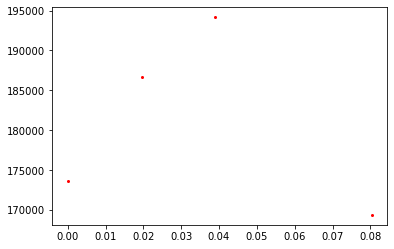

In [13]:
our_tz = BinnedTimeSeries.read(
    './results/tzboo_results.csv',
    time_bin_start_column='time_bin_start',
    time_bin_size_column='time_bin_size',
    time_bin_size_unit=u.s
)
our_jd_tz = our_tz.time_bin_start.jd - our_tz.time_bin_start.jd.min()
plt.plot(our_jd_tz, our_tz['AP flux'], 'r.', markersize=4, label='AP rel. flux')
# plt.plot(cc_com['HJD'] - cc_com['HJD'].min(), cc_com['V Band Rel Flux'], '.', markersize=4)

$$\displaystyle - \frac{\phi^{2} a}{2} - \phi a b x - \frac{a b^{2} x^{2}}{2} + a$$
- $a^\prime = -ab^2 / 2$
- $b^\prime = -\phi a b$
- $c^\prime = a(1-\phi^2/2)$

In [95]:
from sympy import *
a, b, x, phi = symbols(r'a b x \phi')

expr = a * (1 - (b * x + phi) ** 2 / 2)
expr.expand()

-\phi**2*a/2 - \phi*a*b*x - a*b**2*x**2/2 + a

In [15]:
from lmfit.models import SineModel, QuadraticModel, Model

our_tz = BinnedTimeSeries.read(
    './results/tzboo_results.csv',
    time_bin_start_column='time_bin_start',
    time_bin_size_column='time_bin_size',
    time_bin_size_unit=u.s
)

our_jd_tz = our_tz.time_bin_start.jd - our_tz.time_bin_start.jd.min()

def second_order_cos(x, a, b, phi):
    return a * (1 - (b * x + phi) ** 2 / 2)

quad = QuadraticModel()
# quad = Model(second_order_cos)
rel_flux = our_tz['AP flux'] / our_tz['AP flux'].max()
param_guess = quad.guess(rel_flux, x=our_jd_tz)
print(param_guess)
quad_fit = quad.fit(rel_flux, param_guess, x=our_jd_tz)
# result = quad.fit(rel_flux, x=our_jd, a=5, b=5, phi=5)
# result.params['a'].value
quad_fit.params

Parameters([('a', <Parameter 'a', value=-69.1035476631917, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=5.335324996418381, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=0.8910592917421547, bounds=[-inf:inf]>)])


name,value,standard error,relative error,initial value,min,max,vary
a,-69.1035477,7.38807346,(10.69%),-69.1035476631917,-inf,inf,True
b,5.33532500,0.64259541,(12.04%),5.335324996418381,-inf,inf,True
c,0.89105929,0.01007611,(1.13%),0.8910592917421547,-inf,inf,True


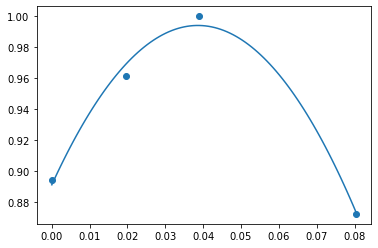

In [16]:
fit_domain = np.linspace(our_jd_tz.min(), our_jd_tz.max(), 100)
plt.plot(fit_domain, quad_fit.eval(x=fit_domain))
plt.scatter(our_jd_tz, rel_flux)

In [24]:
from lmfit.models import SineModel, QuadraticModel, Model

our_cc = BinnedTimeSeries.read(
    './results/cccom_results.csv',
    time_bin_start_column='time_bin_start',
    time_bin_size_column='time_bin_size',
    time_bin_size_unit=u.s
)

our_jd_cc = our_cc.time_bin_start.jd - our_cc.time_bin_start.jd.min()
fit_domain = np.linspace(our_jd_cc.min(), our_jd_cc.max(), 100)
plt.plot(fit_domain, quad_fit.eval(x=fit_domain))
plt.scatter(our_jd_cc, rel_flux)
def second_order_cos(x, a, b, phi):
    return a * (1 - (b * x + phi) ** 2 / 2)

quad = QuadraticModel()
# quad = Model(second_order_cos)
rel_flux = our_cc['AP flux'] / our_cc['AP flux'].max()
param_guess = quad.guess(rel_flux, x=our_jd_cc)
quad_fit = quad.fit(rel_flux, param_guess, x=our_jd_cc)
# result = quad.fit(rel_flux, x=our_jd, a=5, b=5, phi=5)
# result.params['a'].value
quad_fit.params

name,value,standard error,relative error,initial value,min,max,vary
a,32.0760171,0.00000000,(0.00%),32.07601712882609,-inf,inf,True
b,-3.28070417,0.00000000,(0.00%),-3.2807041671743264,-inf,inf,True
c,1.00000000,0.00000000,(0.00%),0.9999999999999997,-inf,inf,True


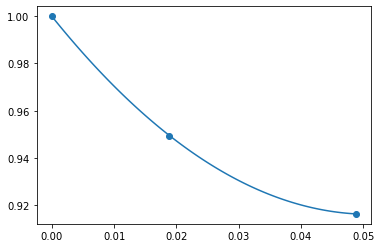

In [25]:
fit_domain = np.linspace(our_jd_cc.min(), our_jd_cc.max(), 100)
plt.plot(fit_domain, quad_fit.eval(x=fit_domain))
plt.scatter(our_jd_cc, rel_flux)

In [10]:
a = quad_fit.params['a'].value
b = quad_fit.params['b'].value
c = quad_fit.params['c'].value
period = 2 * np.pi / np.sqrt(np.abs(2 * a / (b ** 2 / (4 * a) - c)))
period

0.7508431425233466

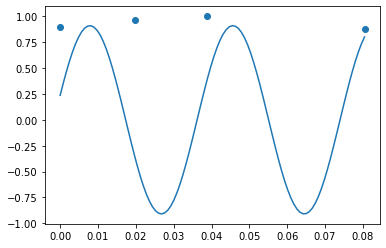

In [93]:
sine = SineModel()
sine_guess = sine.guess(rel_flux, x=our_jd)
sine_fit = sine.fit(rel_flux, sine_guess, x=our_jd)
fit_domain = np.linspace(our_jd.min(), our_jd.max(), 100)
plt.plot(fit_domain, sine_fit.eval(x=fit_domain))
plt.scatter(our_jd, rel_flux)

## Pipeline: Apply taylor expansion of sinusoid fit curve and save statistics to a file

In [26]:
from lmfit.models import SineModel, QuadraticModel, Model
import pandas as pd

def taylor_fit(data_path, results_path):
    time_series = BinnedTimeSeries.read(
        data_path,
        time_bin_start_column='time_bin_start',
        time_bin_size_column='time_bin_size',
        time_bin_size_unit=u.s
    )
    
    quad = QuadraticModel()
    time_domain = time_series.time_bin_start.jd - time_series.time_bin_start.jd.min()
    rel_flux = time_series['AP flux'] / time_series['AP flux'].max()
    param_guess = quad.guess(rel_flux, x=time_domain)
    quad_fit = quad.fit(rel_flux, param_guess, x=time_domain)
    
    a = quad_fit.params['a'].value
    b = quad_fit.params['b'].value
    c = quad_fit.params['c'].value
    # period = 2 * np.pi / np.sqrt(np.abs(2 * a / (b ** 2 / (4 * a) - c)))
    period = np.sqrt(np.abs(np.pi ** 2 / a))
    
    results = pd.DataFrame({
        'a' : [a],
        'b' : [b],
        'c' : [c],
        'period' : [period]
    })
    
    results.to_csv(results_path)
    return results

In [27]:
tz_fit_params = taylor_fit('./results/tzboo_results.csv', './results/tz_fit_params.csv')
tz_fit_params

,a,b,c,period
0,-72.571828,5.642695,0.887929,0.368779


In [28]:
cc_fit_params = taylor_fit('./results/cccom_results.csv', './results/cc_fit_params.csv')
cc_fit_params

,a,b,c,period
0,-114.054855,6.67947,0.914525,0.294166
